# Import necessary libraries

In [34]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import plotly.express as px
from prophet.plot import plot_plotly
import seaborn as sns
 
%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

# Read in the data

Read the data in from the retail sales CSV file in the examples folder then set the index to the 'date' column. We are also parsing dates in the data file.

In [35]:
data = pd.read_csv('./Data/tube_time_interval_data.csv') 

# To set date as index, use: index_col='entry_date_time', parse_dates=True

In [36]:
data.head()

,entry_date_time,time,mode,nlc,asc,station,coverage,year_of_entry,day,dir,time_intervals,counts
0,2017-12-26 05:15,05:15,LU,500,ACTu,Acton Town,Station entry / exit,2017,MTF,IN,0500-0515,22.0
1,2017-12-26 05:15,05:15,LU,502,ALDu,Aldgate,Station entry / exit,2017,MTF,IN,0500-0515,11.0
2,2017-12-26 05:15,05:15,LU,503,ALEu,Aldgate East,Station entry / exit,2017,MTF,IN,0500-0515,6.0
3,2017-12-26 05:15,05:15,LU,505,ALPu,Alperton,Station entry / exit,2017,MTF,IN,0500-0515,15.0
4,2017-12-26 05:15,05:15,LU,506,AMEu,Amersham,Station entry / exit,2017,MTF,IN,0500-0515,1.0


In [37]:
data['counts'] = round(data['counts'])

In [38]:
data.head()

,entry_date_time,time,mode,nlc,asc,station,coverage,year_of_entry,day,dir,time_intervals,counts
0,2017-12-26 05:15,05:15,LU,500,ACTu,Acton Town,Station entry / exit,2017,MTF,IN,0500-0515,22.0
1,2017-12-26 05:15,05:15,LU,502,ALDu,Aldgate,Station entry / exit,2017,MTF,IN,0500-0515,11.0
2,2017-12-26 05:15,05:15,LU,503,ALEu,Aldgate East,Station entry / exit,2017,MTF,IN,0500-0515,6.0
3,2017-12-26 05:15,05:15,LU,505,ALPu,Alperton,Station entry / exit,2017,MTF,IN,0500-0515,15.0
4,2017-12-26 05:15,05:15,LU,506,AMEu,Amersham,Station entry / exit,2017,MTF,IN,0500-0515,1.0


In [39]:
# Setting the dataframe manipulation results to show all the rows and columns without breaking
pd.set_option("display.max_columns", None)

pd.set_option("display.max_rows", None)

In [40]:
data_sorted = data.sort_values('asc')

In [41]:
data_sorted.sort_values(['asc', 'time'], ascending=[True, True]).head(10)

,entry_date_time,time,mode,nlc,asc,station,coverage,year_of_entry,day,dir,time_intervals,counts
756653,2018-12-27 00:00,00:00,LU,500,ACT,Acton Town,Station entry / exit,2018,SAT,OUT,2345-0000,92.0
756918,2018-12-28 00:00,00:00,LU,500,ACT,Acton Town,Station entry / exit,2018,SUN,IN,2345-0000,7.0
757183,2018-12-28 00:00,00:00,LU,500,ACT,Acton Town,Station entry / exit,2018,SUN,OUT,2345-0000,50.0
755593,2018-12-25 00:00,00:00,LU,500,ACT,Acton Town,Station entry / exit,2018,MTT,OUT,2345-0000,64.0
755858,2018-12-26 00:00,00:00,LU,500,ACT,Acton Town,Station entry / exit,2018,FRI,IN,2345-0000,21.0
756123,2018-12-26 00:00,00:00,LU,500,ACT,Acton Town,Station entry / exit,2018,FRI,OUT,2345-0000,80.0
756388,2018-12-27 00:00,00:00,LU,500,ACT,Acton Town,Station entry / exit,2018,SAT,IN,2345-0000,26.0
755328,2018-12-25 00:00,00:00,LU,500,ACT,Acton Town,Station entry / exit,2018,MTT,IN,2345-0000,9.0
766703,2018-12-27 00:15,00:15,LU,500,ACT,Acton Town,Station entry / exit,2018,SAT,OUT,0000-0015,81.0
766968,2018-12-28 00:15,00:15,LU,500,ACT,Acton Town,Station entry / exit,2018,SUN,IN,0000-0015,3.0


In [42]:
# data_sorted.to_csv('tube_time_interval_data_sorted.csv', index=False)

In [43]:
data_sorted.shape

(964800, 12)

In [44]:
data_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 964800 entries, 102873 to 591333
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   entry_date_time  964800 non-null  object 
 1   time             964800 non-null  object 
 2   mode             964800 non-null  object 
 3   nlc              964800 non-null  int64  
 4   asc              964800 non-null  object 
 5   station          964800 non-null  object 
 6   coverage         964800 non-null  object 
 7   year_of_entry    964800 non-null  int64  
 8   day              964800 non-null  object 
 9   dir              964800 non-null  object 
 10  time_intervals   964800 non-null  object 
 11  counts           964800 non-null  float64
dtypes: float64(1), int64(2), object(9)
memory usage: 95.7+ MB


In [45]:
data_sorted['station'].unique()

array(['Acton Town', 'Arnos Grove', 'Aldgate', 'Aldgate East', 'Alperton',
       'Amersham', 'Angel', 'Archway', 'Arsenal', 'Balham LU', 'Barbican',
       'Bayswater', 'Bromley-by-Bow', 'Barons Court', 'Barkingside',
       'Bond Street', 'Becontree', 'Bermondsey', 'Bounds Green',
       'Buckhurst Hill', 'Blackhorse Road', 'Barking', 'Blackfriars LU',
       'Bethnal Green LU', 'Bank and Monument', 'Borough', 'Boston Manor',
       'Belsize Park', 'Battersea Power Station', 'Brixton LU',
       'Baker Street', 'Brent Cross', 'Burnt Oak', 'Bow Road',
       'Cockfosters', 'Chalk Farm', 'Chigwell', 'Chesham',
       'Chiswick Park', 'Charing Cross LU', 'Chalfont & Latimer',
       'Colliers Wood', 'Canning Town', 'Colindale', 'Covent Garden',
       'Clapham Common', 'Canons Park', 'Clapham North', 'Clapham South',
       'Caledonian Road', 'Croxley', 'Cannon Street LU', 'Camden Town',
       'Chorleywood', 'Canary Wharf LU', 'Canada Water', 'Chancery Lane',
       'Debden', 'Dagenham

Given the numerous list of stations as printed above, it is really hard for we to tell exactly how many they are. 
To do this, we can use a ***for loop*** control to count the number of stations and print the numerical value. The code below performs the action and gives the output.

In [46]:
# loop for counting the unique
# values in station
stations = []
cnt = 0
for i in range(0, len(data_sorted['station'])):
    
    if data_sorted['station'][i] not in stations: 
        
        stations.append(data_sorted['station'][i])
          
        cnt += 1

print("Number of unique stations: ", cnt)

Number of unique stations:  267


From the result of the station counting, we can see that we have a whooping ***267 stations*** in the ***London Underground Rail Network (The Tube)***. This actually is a huge number to carter for in this project, so the focus will be given to the most busiest stations according to the historical data. 

***Let us begin!***

In [47]:
# Viewing the sorted dataset according the station names
df = data_sorted[['entry_date_time', 'station', 'year_of_entry', 'day', 'dir', 'counts' ]]
df.head()

,entry_date_time,station,year_of_entry,day,dir,counts
102873,2018-12-26 07:45,Acton Town,2018,FRI,OUT,230.0
33318,2018-12-28 06:00,Acton Town,2018,SUN,IN,16.0
685508,2018-12-26 22:15,Acton Town,2018,FRI,IN,39.0
685243,2018-12-25 22:15,Acton Town,2018,MTT,OUT,113.0
684978,2018-12-25 22:15,Acton Town,2018,MTT,IN,27.0


From the records on the top view of the dataset above, we can decipher that there are a lot of stations with low passenger patronage but the focus of this project is basically on the lines with highest weight. this is understandable so since we won't be observing all the lines in the London Underground.

The code below helps us view the top records in the data with the highest number of passenger flows (***Passenger Counts***), including the stations.

In [48]:
#Sorting the dataset according to the number of counts in descending order
df_top = data_sorted.sort_values('counts', ascending=False)
df_top.head()

,entry_date_time,time,mode,nlc,asc,station,coverage,year_of_entry,day,dir,time_intervals,counts
152604,2018-12-25 09:00,09:00,LU,513,BNK,Bank and Monument,Station entry / exit,2018,MTT,OUT,0845-0900,8060.0
154724,2019-12-25 09:00,09:00,LU,513,BNKu,Bank and Monument,Station entry / exit,2019,MTT,OUT,0845-0900,8004.0
151024,2017-12-26 09:00,09:00,LU,513,BNKu,Bank and Monument,Station entry / exit,2017,MTF,OUT,0845-0900,7965.0
144640,2019-12-25 08:45,08:45,LU,747,WLOu,Waterloo LU,Station entry / exit,2019,MTT,IN,0830-0845,7939.0
124540,2019-12-25 08:15,08:15,LU,747,WLOu,Waterloo LU,Station entry / exit,2019,MTT,IN,0800-0815,7748.0


In [49]:
# Observe the shape of the ***df_top***
df_top.shape

(964800, 12)

In [50]:
# Viewing the top records with count of passengers over 3000
df_top = data_sorted.loc[df.counts > 3000]
df_top = df_top.sort_values('counts', ascending=False)
df_top.head(10)

,entry_date_time,time,mode,nlc,asc,station,coverage,year_of_entry,day,dir,time_intervals,counts
152604,2018-12-25 09:00,09:00,LU,513,BNK,Bank and Monument,Station entry / exit,2018,MTT,OUT,0845-0900,8060.0
154724,2019-12-25 09:00,09:00,LU,513,BNKu,Bank and Monument,Station entry / exit,2019,MTT,OUT,0845-0900,8004.0
151024,2017-12-26 09:00,09:00,LU,513,BNKu,Bank and Monument,Station entry / exit,2017,MTF,OUT,0845-0900,7965.0
144640,2019-12-25 08:45,08:45,LU,747,WLOu,Waterloo LU,Station entry / exit,2019,MTT,IN,0830-0845,7939.0
124540,2019-12-25 08:15,08:15,LU,747,WLOu,Waterloo LU,Station entry / exit,2019,MTT,IN,0800-0815,7748.0
140974,2017-12-26 08:45,08:45,LU,513,BNKu,Bank and Monument,Station entry / exit,2017,MTF,OUT,0830-0845,7550.0
164774,2019-12-25 09:15,09:15,LU,513,BNKu,Bank and Monument,Station entry / exit,2019,MTT,OUT,0900-0915,7524.0
134590,2019-12-25 08:30,08:30,LU,747,WLOu,Waterloo LU,Station entry / exit,2019,MTT,IN,0815-0830,7468.0
153134,2018-12-26 09:00,09:00,LU,513,BNK,Bank and Monument,Station entry / exit,2018,FRI,OUT,0845-0900,7451.0
130890,2017-12-26 08:30,08:30,LU,747,WLOu,Waterloo LU,Station entry / exit,2017,MTF,IN,0815-0830,7392.0


The following list of stations are those captured in the dataset above with passenger counts greater than 3000 for the corresponding years in the daily 15 minutes time interval. These stations will be our main focus of interest in this exploration and also in the passenger counts forecasting as understanding the factors contributing to the busy passenger flow (IN and OUT) of the station will help us make good recommendations to TFL on improving the London Underground (The Tube) network lines

In [51]:
# pip install "notebook>=5.3" "ipywidgets>=7.2"

In [57]:
import plotly.graph_objects as go

df = df_top.head(100)
fig = px.bar(df, x='time', y = 'counts', color='station')

fig.show()

<function matplotlib.pyplot.show(close=None, block=None)>

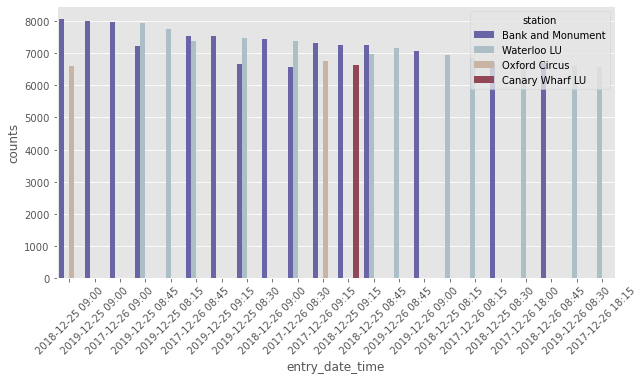

In [63]:
from plotly.offline import plot
plt.figure(figsize = (10,5))

sns.barplot(x = 'entry_date_time', y = 'counts', data = df_top.sort_values('counts', ascending=False).head(30),  
            hue='station', 
            palette='twilight_shifted', lw=3)
plt.xticks(rotation=45)
plt.show

In [64]:
# Viewing the names of the stations with highest passenger counts 
top_stations = df_top['station'].unique()
top_stations = pd.DataFrame(top_stations, columns=['Top Stations'])
top_stations

,Top Stations
0,Bank and Monument
1,Waterloo LU
2,Oxford Circus
3,Canary Wharf LU
4,Liverpool Street LU
5,Moorgate
6,London Bridge LU
7,Farringdon
8,Victoria LU
9,Green Park


## Creating a Dataframe of the stations of interest

In [65]:
list_station = ['Bank and Monument', 'Waterloo LU', 'Oxford Circus',
       'Canary Wharf LU', 'Liverpool Street LU', 'Moorgate',
       'London Bridge LU', 'Farringdon', 'Victoria LU', 'Green Park']
df_station = data_sorted.loc[data_sorted['station'].isin(list_station)]

In [66]:
df_station.head()

,entry_date_time,time,mode,nlc,asc,station,coverage,year_of_entry,day,dir,time_intervals,counts
22219,2018-12-26 05:45,05:45,LU,513,BNK,Bank and Monument,Station entry / exit,2018,FRI,IN,0530-0545,27.0
224544,2018-12-28 10:45,10:45,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SUN,OUT,1030-1045,358.0
585549,2018-12-27 19:45,19:45,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SAT,IN,1930-1945,384.0
405179,2018-12-28 15:15,15:15,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SUN,IN,1500-1515,409.0
676529,2018-12-28 22:00,22:00,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SUN,IN,2145-2200,142.0


In [67]:
df_station.shape

(36480, 12)

In [68]:
# Splitting the dataset by the direction of passenger flow (IN and OUT)
df_in = df_station.loc[data_sorted.dir=='IN']
df_out = df_station.loc[data_sorted.dir=='OUT']

# Creating new dataframes by directions and days
df_in_mtt = df_in.loc[df_in.day=='MTT']
df_out_mtt = df_out.loc[df_out.day=='MTT']

df_in_fri = df_in.loc[df_in.day=='FRI']
df_out_fri = df_out.loc[df_out.day=='FRI']

df_in_sat = df_in.loc[df_in.day=='SAT']
df_out_sat = df_out.loc[df_out.day=='SAT']

df_in_sun = df_in.loc[df_in.day=='SUN']
df_out_sun = df_out.loc[df_out.day=='SUN']

In [69]:
df_in_mtt.head()

,entry_date_time,time,mode,nlc,asc,station,coverage,year_of_entry,day,dir,time_intervals,counts
674939,2018-12-25 22:00,22:00,LU,513,BNK,Bank and Monument,Station entry / exit,2018,MTT,IN,2145-2200,856.0
544289,2018-12-25 18:45,18:45,LU,513,BNK,Bank and Monument,Station entry / exit,2018,MTT,IN,1830-1845,4546.0
212639,2018-12-25 10:30,10:30,LU,513,BNK,Bank and Monument,Station entry / exit,2018,MTT,IN,1015-1030,607.0
333239,2018-12-25 13:30,13:30,LU,513,BNK,Bank and Monument,Station entry / exit,2018,MTT,IN,1315-1330,999.0
403589,2018-12-25 15:15,15:15,LU,513,BNK,Bank and Monument,Station entry / exit,2018,MTT,IN,1500-1515,1362.0


In [70]:
df_in_mtt.shape

(3840, 12)

In [71]:
df_out_mtt.head()

,entry_date_time,time,mode,nlc,asc,station,coverage,year_of_entry,day,dir,time_intervals,counts
735504,2018-12-25 23:30,23:30,LU,513,BNK,Bank and Monument,Station entry / exit,2018,MTT,OUT,2315-2330,87.0
494304,2018-12-25 17:30,17:30,LU,513,BNK,Bank and Monument,Station entry / exit,2018,MTT,OUT,1715-1730,1256.0
936504,2018-12-25 04:30,04:30,LU,513,BNK,Bank and Monument,Station entry / exit,2018,MTT,OUT,0415-0430,0.0
916404,2018-12-25 04:00,04:00,LU,513,BNK,Bank and Monument,Station entry / exit,2018,MTT,OUT,0345-0400,0.0
795804,2018-12-25 01:00,01:00,LU,513,BNK,Bank and Monument,Station entry / exit,2018,MTT,OUT,0045-0100,21.0


In [72]:
df_in_fri.head()

,entry_date_time,time,mode,nlc,asc,station,coverage,year_of_entry,day,dir,time_intervals,counts
22219,2018-12-26 05:45,05:45,LU,513,BNK,Bank and Monument,Station entry / exit,2018,FRI,IN,0530-0545,27.0
916669,2018-12-26 04:00,04:00,LU,513,BNK,Bank and Monument,Station entry / exit,2018,FRI,IN,0345-0400,32.0
675469,2018-12-26 22:00,22:00,LU,513,BNK,Bank and Monument,Station entry / exit,2018,FRI,IN,2145-2200,739.0
404119,2018-12-26 15:15,15:15,LU,513,BNK,Bank and Monument,Station entry / exit,2018,FRI,IN,1500-1515,1424.0
434269,2018-12-26 16:00,16:00,LU,513,BNK,Bank and Monument,Station entry / exit,2018,FRI,IN,1545-1600,1630.0


In [73]:
df_out_fri.head()

,entry_date_time,time,mode,nlc,asc,station,coverage,year_of_entry,day,dir,time_intervals,counts
796334,2018-12-26 01:00,01:00,LU,513,BNK,Bank and Monument,Station entry / exit,2018,FRI,OUT,0045-0100,106.0
12434,2018-12-26 05:30,05:30,LU,513,BNK,Bank and Monument,Station entry / exit,2018,FRI,OUT,0515-0530,7.0
615434,2018-12-26 20:30,20:30,LU,513,BNK,Bank and Monument,Station entry / exit,2018,FRI,OUT,2015-2030,408.0
72734,2018-12-26 07:00,07:00,LU,513,BNK,Bank and Monument,Station entry / exit,2018,FRI,OUT,0645-0700,1373.0
585284,2018-12-26 19:45,19:45,LU,513,BNK,Bank and Monument,Station entry / exit,2018,FRI,OUT,1930-1945,641.0


In [74]:
df_in_sat.head()

,entry_date_time,time,mode,nlc,asc,station,coverage,year_of_entry,day,dir,time_intervals,counts
585549,2018-12-27 19:45,19:45,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SAT,IN,1930-1945,384.0
495099,2018-12-27 17:30,17:30,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SAT,IN,1715-1730,620.0
334299,2018-12-27 13:30,13:30,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SAT,IN,1315-1330,545.0
675999,2018-12-27 22:00,22:00,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SAT,IN,2145-2200,266.0
545349,2018-12-27 18:45,18:45,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SAT,IN,1830-1845,518.0


In [75]:
df_out_sat.head()

,entry_date_time,time,mode,nlc,asc,station,coverage,year_of_entry,day,dir,time_intervals,counts
545614,2018-12-27 18:45,18:45,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SAT,OUT,1830-1845,509.0
63214,2018-12-27 06:45,06:45,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SAT,OUT,0630-0645,135.0
43114,2018-12-27 06:15,06:15,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SAT,OUT,0600-0615,50.0
334564,2018-12-27 13:30,13:30,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SAT,OUT,1315-1330,506.0
73264,2018-12-27 07:00,07:00,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SAT,OUT,0645-0700,154.0


In [76]:
df_in_sun.head()

,entry_date_time,time,mode,nlc,asc,station,coverage,year_of_entry,day,dir,time_intervals,counts
405179,2018-12-28 15:15,15:15,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SUN,IN,1500-1515,409.0
676529,2018-12-28 22:00,22:00,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SUN,IN,2145-2200,142.0
756929,2018-12-28 00:00,00:00,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SUN,IN,2345-0000,29.0
214229,2018-12-28 10:30,10:30,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SUN,IN,1015-1030,179.0
354929,2018-12-28 14:00,14:00,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SUN,IN,1345-1400,362.0


In [77]:
df_out_sun.head()

,entry_date_time,time,mode,nlc,asc,station,coverage,year_of_entry,day,dir,time_intervals,counts
224544,2018-12-28 10:45,10:45,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SUN,OUT,1030-1045,358.0
294894,2018-12-28 12:30,12:30,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SUN,OUT,1215-1230,366.0
33594,2018-12-28 06:00,06:00,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SUN,OUT,0545-0600,18.0
767244,2018-12-28 00:15,00:15,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SUN,OUT,0000-0015,21.0
405444,2018-12-28 15:15,15:15,LU,513,BNK,Bank and Monument,Station entry / exit,2018,SUN,OUT,1500-1515,337.0


In [78]:
data = df_in_mtt.loc[df_in_mtt.year_of_entry==2021]
data.head()

,entry_date_time,time,mode,nlc,asc,station,coverage,year_of_entry,day,dir,time_intervals,counts
852141,2021-12-25 02:15,02:15,LU,513,BNKu,Bank and Monument,Station entry / exit,2021,MTT,IN,0200-0215,0.0
359691,2021-12-25 14:00,14:00,LU,513,BNKu,Bank and Monument,Station entry / exit,2021,MTT,IN,1345-1400,397.0
68241,2021-12-25 06:45,06:45,LU,513,BNKu,Bank and Monument,Station entry / exit,2021,MTT,IN,0630-0645,110.0
550641,2021-12-25 18:45,18:45,LU,513,BNKu,Bank and Monument,Station entry / exit,2021,MTT,IN,1830-1845,1949.0
500391,2021-12-25 17:30,17:30,LU,513,BNKu,Bank and Monument,Station entry / exit,2021,MTT,IN,1715-1730,2415.0


2019


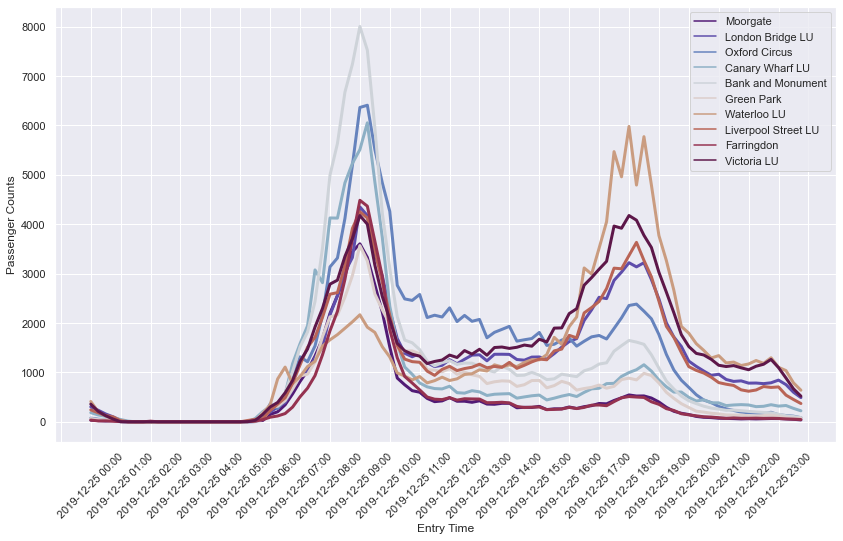

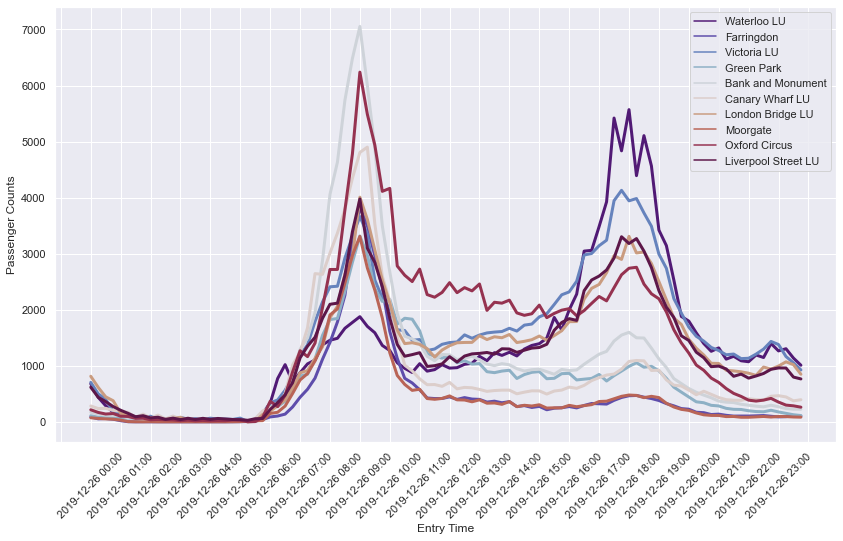

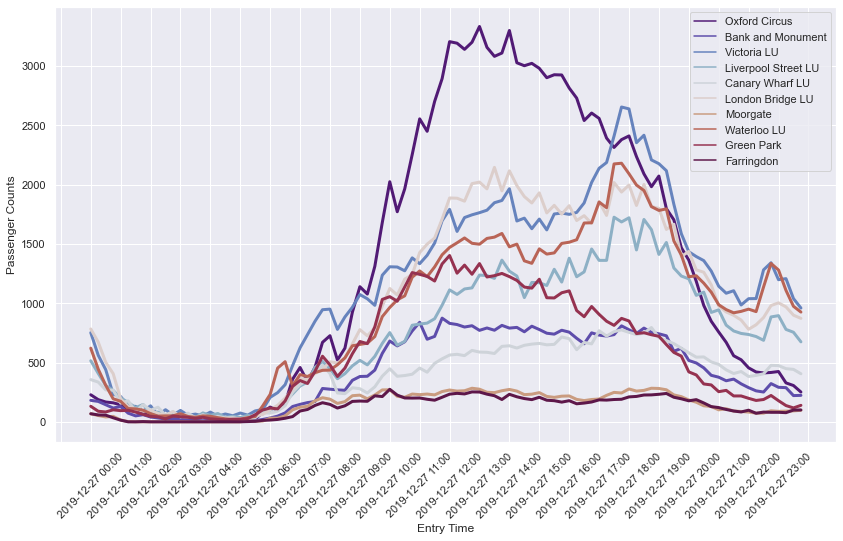

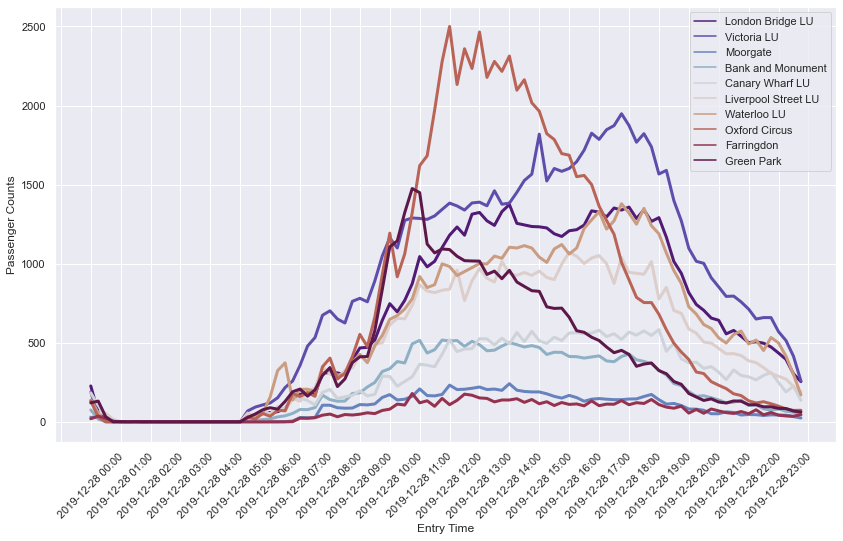

In [79]:
import matplotlib.ticker as ticker

df_list = [df_out_mtt, df_out_fri, df_out_sat, df_out_sun]
year = int (input())
for df in df_list:
    
    data = df.loc[df.year_of_entry==year]
    
    sns.set_style('darkgrid')
    sns.set(rc={'figure.figsize':(14,8)})

    ax = sns.lineplot(data=data.sort_values('entry_date_time', ascending=True), x ='entry_date_time', y = 'counts',
                      hue='station', palette='twilight_shifted',
                      legend='full', lw=3)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    
    plt.ylabel('Passenger Counts')
    plt.xlabel('Entry Time')
    plt.show()
    

In the table above, we can now clearly see the stations to focus on forcasting passenger counts for. We can view these stations independently to see the ***the peak times*** of ***passenger counts*** in all the years in the historical data. 

In [77]:
df_top['station'].unique()

array(['Bank and Monument', 'Waterloo LU', 'Oxford Circus',
       'Canary Wharf LU', 'Liverpool Street LU', 'Moorgate',
       'London Bridge LU', 'Farringdon', 'Victoria LU', 'Green Park',
       "King's Cross St. Pancras", 'Holborn', 'Brixton LU', 'Stratford',
       'Finsbury Park'], dtype=object)

# Begin Forecast

In [257]:
def get_data(df, station, day, dire):
    
    df = df
    station = station
    day = day
    dire = dire
    
    data_in_sorted = df.sort_values(['asc', 'time'], ascending=[True, True])
    df_in_new = data_in_sorted.loc[data_in_sorted.station==station]
    df_in_new = df_in_new.loc[df_in_new.day==day]
    df_in_new = df_in_new.loc[df_in_new.dir==dire]
    
    df_in_new = df_in_new.sort_values(['year_of_entry'], ascending=True)
    df_in_new = df_in_new[['entry_date_time', 'counts']]
    
    return df_in_new

In [258]:
def get_data_year(df, station, day, dire, year):
    
    df = df
    station = station
    day = day
    dire = dire
    year = year
    
    data_in_sorted = df.sort_values(['asc', 'time'], ascending=[True, True])
    df_in_new = data_in_sorted.loc[data_in_sorted.station==station]
    df_in_new = df_in_new.loc[df_in_new.day==day]
    df_in_new = df_in_new.loc[df_in_new.dir==dire]
    df_in_new_year = df_in_new.loc[df_in_new.year_of_entry==year]
    
    df_in_new_year = df_in_new_year[['entry_date_time', 'counts']]
    
    return df_in_new_year

In [259]:
list_station = ['Acton Town', 'Arnos Grove', 'Aldgate', 'Aldgate East', 'Alperton',
       'Amersham', 'Angel', 'Archway', 'Arsenal', 'Balham LU', 'Barbican',
       'Bayswater', 'Bromley-by-Bow', 'Barons Court', 'Barkingside',]
list_day = ['MTT', 'FRI', 'SAT', 'SUN']
list_dir = ['IN', 'OUT']
list_year = [2017, 2018, 2019, 2020, 2021]

In [185]:
station = input()
day = input()
dire = input()

Angel
MTT
OUT


In [189]:
count_df = get_data(data_sorted, station, day, dire)

In [190]:
count_df.head()

,entry_date_time,counts
755598,2018-12-25 00:00,76.0
484248,2018-12-25 17:15,379.0
474198,2018-12-25 17:00,403.0
464148,2018-12-25 16:45,399.0
454098,2018-12-25 16:30,282.0


In [260]:
station = input()
day = input()
dire = input()
year = int (input())

Acton Town
MTT
IN
2017


In [261]:
count_df_year = get_data_year(data_sorted, station, day, dir, year)

In [262]:
count_df_year.head()

,entry_date_time,counts


# Prepare for Prophet

For prophet to work, we need to change the names of these columns to 'ds' and 'y', so lets just create a new dataframe and keep our old one handy (you'll see why later). The new dataframe will initially be created with an integer index so we can rename the columns

In [229]:
# df = count_df.reset_index()

In [230]:
df = count_df.sort_values('entry_date_time')

In [231]:
df.head()

,entry_date_time,counts
755598,2018-12-25 00:00,76.0
765648,2018-12-25 00:15,46.0
775698,2018-12-25 00:30,37.0
785748,2018-12-25 00:45,20.0
795798,2018-12-25 01:00,3.0


In [232]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384 entries, 755598 to 751900
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   entry_date_time  384 non-null    object 
 1   counts           384 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.0+ KB


Let's rename the columns as required by fbprophet. Additioinally, fbprophet doesn't like the index to be a datetime...it wants to see 'ds' as a non-index column, so we won't set an index differnetly than the integer index.

In [233]:
df=df.rename(columns={'entry_date_time':'ds', 'counts':'y'})

In [234]:
df.head()

,ds,y
755598,2018-12-25 00:00,76.0
765648,2018-12-25 00:15,46.0
775698,2018-12-25 00:30,37.0
785748,2018-12-25 00:45,20.0
795798,2018-12-25 01:00,3.0


Now's a good time to take a look at your data.  Plot the data using pandas' ```plot``` function

<AxesSubplot:xlabel='ds'>

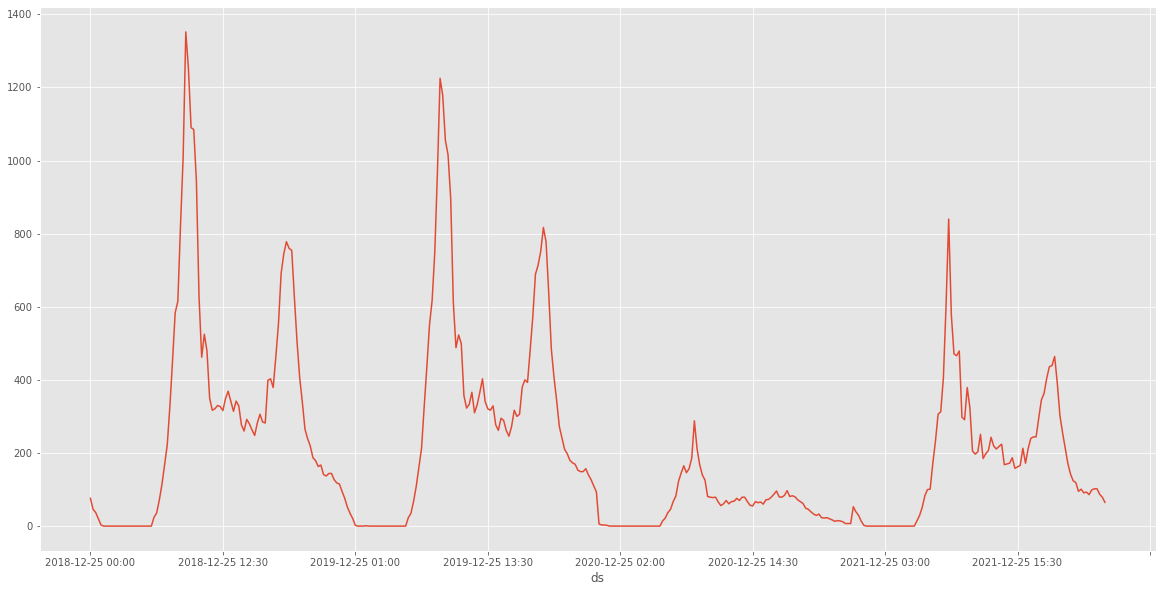

In [235]:
df.set_index('ds').y.plot()

<AxesSubplot:xlabel='ds'>

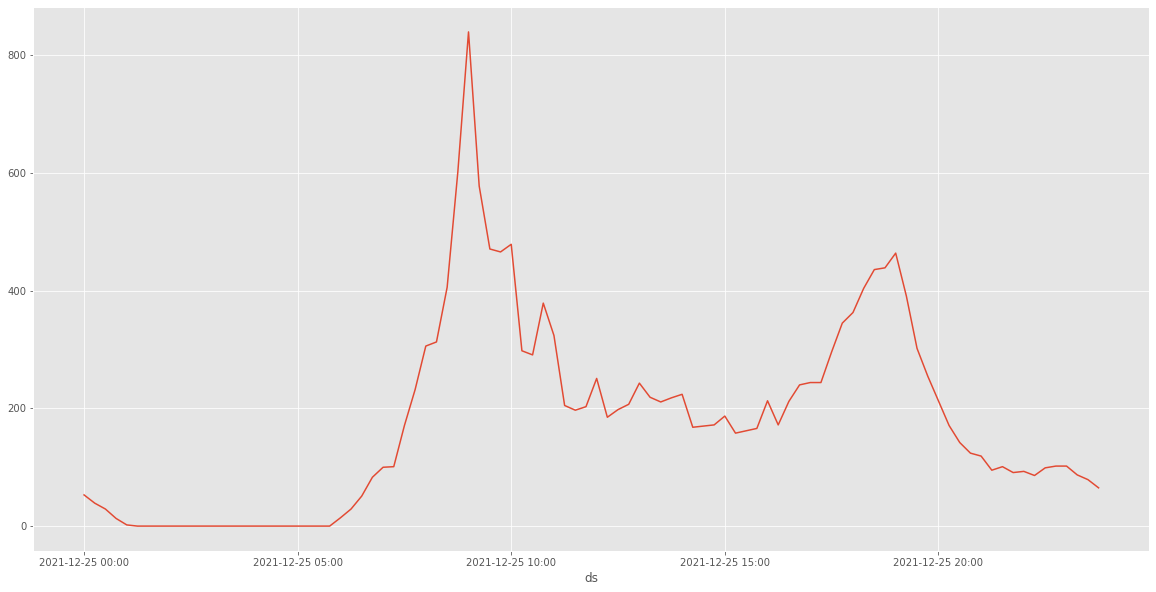

In [219]:
df2 = count_df_year.sort_values('entry_date_time')
df2=df2.rename(columns={'entry_date_time':'ds', 'counts':'y'})
df2.set_index('ds').y.plot()

When working with time-series data, its good to take a look at the data to determine if trends exist, whether it is stationary, has any outliers and/or any other anamolies. 

# Running Prophet

Now, let's set prophet up to begin modeling our data.

Note: Since we are using minutes interval data, you'll see a message from Prophet saying ```Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.```  This is OK since we are workign with monthly data but you can disable it by using ```weekly_seasonality=True``` in the instantiation of Prophet.

In [236]:
model = Prophet(interval_width=0.95, daily_seasonality=True, weekly_seasonality=False)
model.fit(df)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Forecasting is fairly useless unless you can look into the future, so we need to add some future dates to our dataframe. For this example, we want to forecast in the entire 15 minutes interval in a particular week day in the coming week into , so I'll built a future dataframe with 96 periods since we are have 96 units of 15 minutes in a day. Note the ```freq='15T'``` inclusion to ensure we are adding 24 months of data.

In [237]:
# m = Prophet(interval_width=0.95, daily_seasonality=True)
# model = m.fit(df)

# future = m.make_future_dataframe(periods=96,freq='15T')
# forecast = m.predict(future)
# forecast.head()

# plot1 = m.plot(forecast)

In [238]:
future = model.make_future_dataframe(periods=480,freq='15T')
future.tail()

# future = model.make_future_dataframe(periods=96, freq = '15T')
# future.tail()

,ds
859,2021-12-30 22:45:00
860,2021-12-30 23:00:00
861,2021-12-30 23:15:00
862,2021-12-30 23:30:00
863,2021-12-30 23:45:00


To forecast this future data, we need to run it through Prophet's model.

In [239]:
forecast = model.predict(future)

The resulting forecast dataframe contains quite a bit of data, but we really only care about a few columns.  First, let's look at the full dataframe:

In [240]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
859,2021-12-30 22:45:00,18.791148,75.890053,560.148135,18.790932,18.791396,297.741109,297.741109,297.741109,-215.620888,-215.620888,-215.620888,48.598051,48.598051,48.598051,464.763946,464.763946,464.763946,0.0,0.0,0.0,316.532258
860,2021-12-30 23:00:00,18.790622,41.030499,551.560810,18.790404,18.790870,290.449598,290.449598,290.449598,-218.379765,-218.379765,-218.379765,43.548067,43.548067,43.548067,465.281296,465.281296,465.281296,0.0,0.0,0.0,309.240220
861,2021-12-30 23:15:00,18.790095,48.817433,560.522485,18.789876,18.790345,288.393762,288.393762,288.393762,-215.915918,-215.915918,-215.915918,38.511988,38.511988,38.511988,465.797692,465.797692,465.797692,0.0,0.0,0.0,307.183857
862,2021-12-30 23:30:00,18.789569,46.798410,586.431924,18.789348,18.789819,291.173725,291.173725,291.173725,-208.632294,-208.632294,-208.632294,33.492887,33.492887,33.492887,466.313132,466.313132,466.313132,0.0,0.0,0.0,309.963294
863,2021-12-30 23:45:00,18.789042,83.893068,574.914779,18.788820,18.789293,298.134775,298.134775,298.134775,-197.186674,-197.186674,-197.186674,28.493834,28.493834,28.493834,466.827615,466.827615,466.827615,0.0,0.0,0.0,316.923817


We really only want to look at yhat, yhat_lower and yhat_upper, so we can do that with:

In [241]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
859,2021-12-30 22:45:00,316.532258,75.890053,560.148135
860,2021-12-30 23:00:00,309.240220,41.030499,551.560810
861,2021-12-30 23:15:00,307.183857,48.817433,560.522485
862,2021-12-30 23:30:00,309.963294,46.798410,586.431924
863,2021-12-30 23:45:00,316.923817,83.893068,574.914779


# Plotting Prophet results

Prophet has a plotting mechanism called ```plot```.  This plot functionality draws the original data (black dots), the model (blue line) and the error of the forecast (shaded blue area).

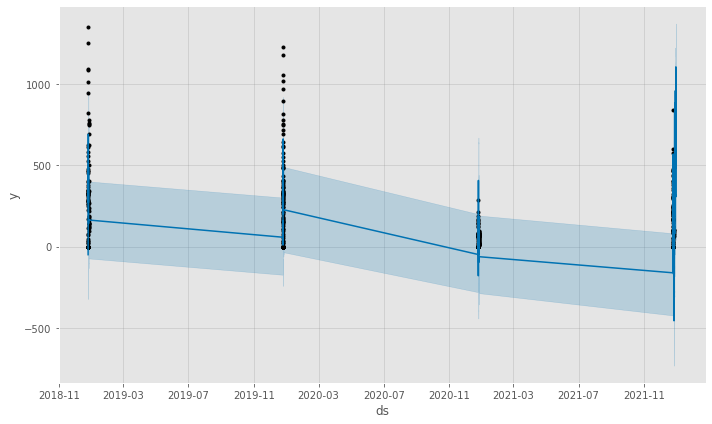

In [242]:
model.plot(forecast);

In [223]:
model2 = model = Prophet(daily_seasonality=True)
model2.fit(df2)
future2 = model.make_future_dataframe(periods=96,freq='15T')
forecast2 = model.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


,ds,yhat,yhat_lower,yhat_upper
187,2021-12-26 22:45:00,186.487468,101.393144,278.064666
188,2021-12-26 23:00:00,186.317282,95.025305,282.980349
189,2021-12-26 23:15:00,190.402331,101.357679,285.422702
190,2021-12-26 23:30:00,198.319337,103.789659,284.665641
191,2021-12-26 23:45:00,209.450192,124.709339,301.441005


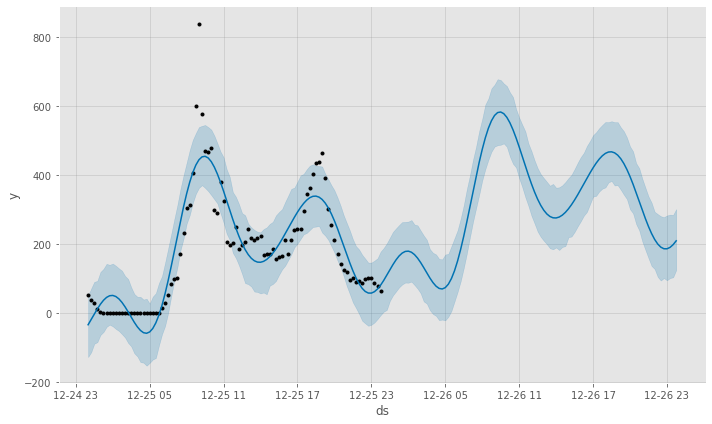

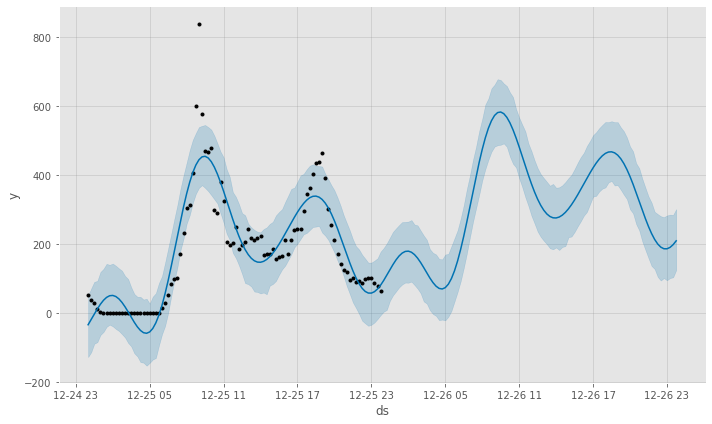

In [225]:
model2.plot(forecast2)

Personally, I'm not a fan of this visualization so I like to break the data up and build a chart myself.  The next section describes how I build my own visualization for Prophet modeling 

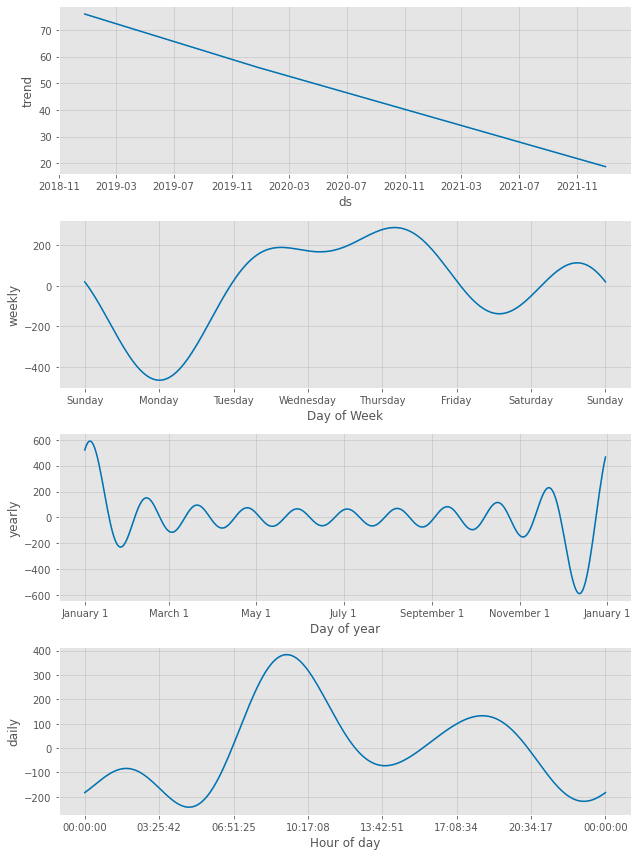

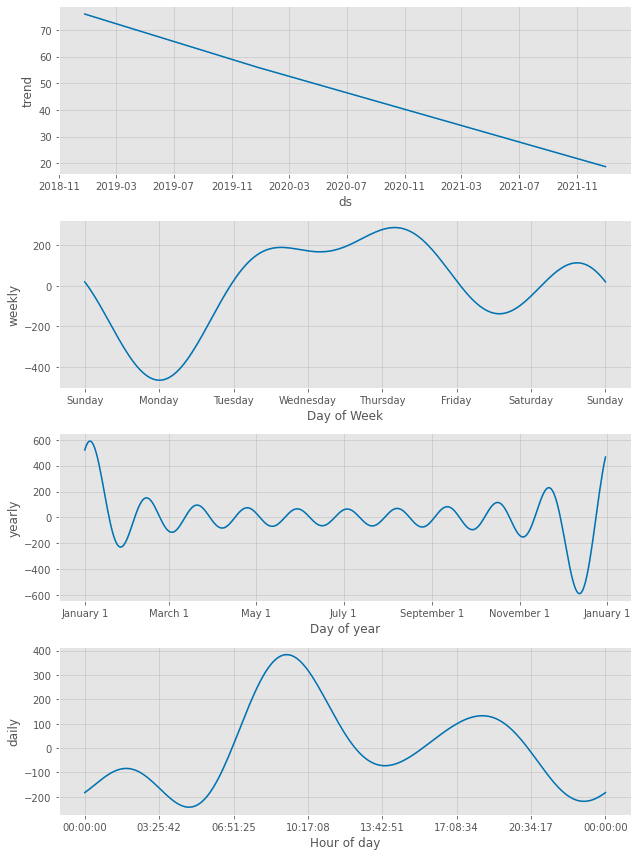

In [243]:
model.plot_components(forecast)

# Visualizing Prophet models

In order to build a useful dataframe to visualize our model versus our original data, we need to combine the output of the Prophet model with our original data set, then we'll build a new chart manually using pandas and matplotlib.

First, let's set our dataframes to have the same index of ```ds```

In [211]:
df.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)

Now, we'll combine the original data and our forecast model data

In [212]:
viz_df = count_df.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

C:\anaconda\lib\site-packages\pandas\core\indexes\base.py:4024: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects
  join_index = self.union(other)


If we look at the ```head()```, we see the data has been joined correctly but the scales of our original data (sales) and our model (yhat) are different. We need to rescale the yhat colums(s) to get the same scale, so we'll use numpy's ```exp``` function to do that.

In [213]:
viz_df.head()

,entry_date_time,counts,yhat,yhat_lower,yhat_upper
2018-12-25 00:00:00,NaN,NaN,197.354453,-72.728684,455.445689
2018-12-25 00:15:00,NaN,NaN,185.697133,-71.002164,452.731175
2018-12-25 00:30:00,NaN,NaN,176.428504,-95.633406,463.024187
2018-12-25 00:45:00,NaN,NaN,169.073115,-101.800174,449.075572
2018-12-25 01:00:00,NaN,NaN,163.062160,-107.917771,442.771381


In [214]:
# viz_df['yhat_rescaled'] = np.exp(viz_df['yhat'])

In [215]:
# viz_df.head()

Let's take a look at the ```counts``` and ```yhat``` data together in a chart.

In [216]:
d = viz_df[['counts', 'yhat']]

In [217]:
d.tail()

,counts,yhat
289600,185.0,NaN
299650,198.0,NaN
309700,207.0,NaN
510700,345.0,NaN
751900,65.0,NaN


<AxesSubplot:>

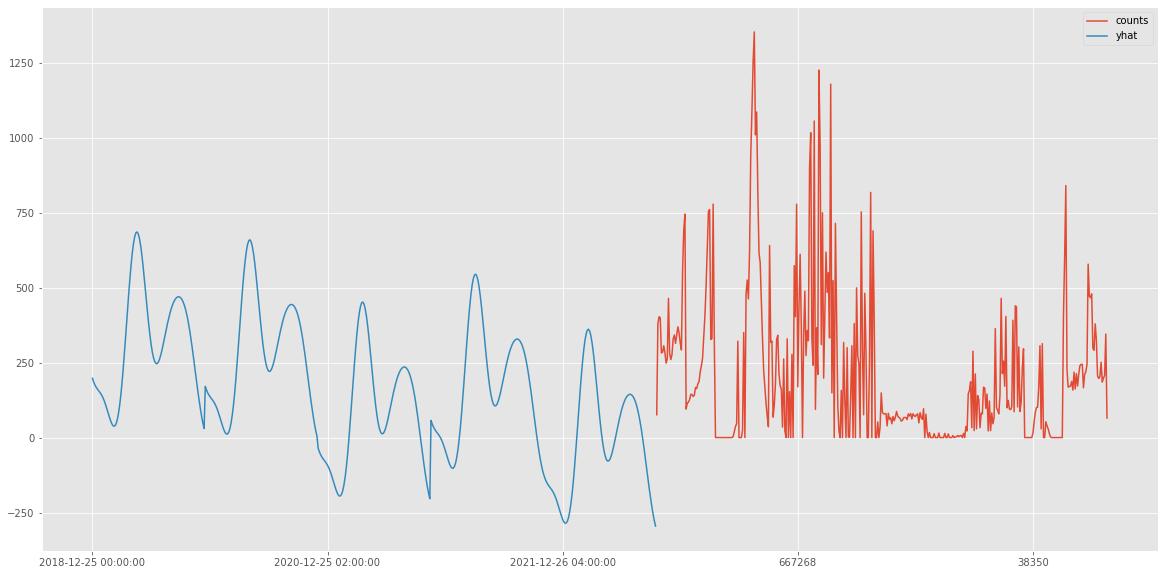

In [218]:
viz_df[['counts', 'yhat']].plot()

You can see from the chart that the model (blue) is pretty good when plotted against the actual signal (orange) but I like to make my vizualization's a little better to understand.   To build my 'better' visualization, we'll need to go back to our original ```data``` and ```forecast``` dataframes.

First things first - we need to find the 2nd to last date of the original sales data in ```data``` in order to ensure the original sales data and model data charts are connected. 

In [117]:
data.index = pd.to_datetime(data.index) #make sure our index as a datetime object
connect_date = data.index[-2] #select the 2nd to last date

Using the ```connect_date``` we can now grab only the model data that after that date (you'll see why in a minute). To do this, we'll mask the forecast data.

In [118]:
mask = (forecast.index > connect_date)
predict_df = forecast.loc[mask]

In [119]:
predict_df.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2018-12-25 00:00:00,63.597056,-76.333834,104.356031,63.597056,63.597056,-51.560707,-51.560707,-51.560707,-44.114468,-44.114468,-44.114468,-12.635788,-12.635788,-12.635788,5.189549,5.189549,5.189549,0.0,0.0,0.0,12.036349
2018-12-25 00:15:00,63.596197,-70.509705,104.754823,63.596197,63.596197,-44.673863,-44.673863,-44.673863,-38.372746,-38.372746,-38.372746,-11.857064,-11.857064,-11.857064,5.555948,5.555948,5.555948,0.0,0.0,0.0,18.922334
2018-12-25 00:30:00,63.595339,-59.139555,119.553854,63.595339,63.595339,-38.639593,-38.639593,-38.639593,-33.476663,-33.476663,-33.476663,-11.085262,-11.085262,-11.085262,5.922331,5.922331,5.922331,0.0,0.0,0.0,24.955745
2018-12-25 00:45:00,63.594480,-53.009062,116.056056,63.594480,63.594480,-33.854516,-33.854516,-33.854516,-29.822669,-29.822669,-29.822669,-10.320546,-10.320546,-10.320546,6.288699,6.288699,6.288699,0.0,0.0,0.0,29.739964
2018-12-25 01:00:00,63.593621,-57.301379,117.853484,63.593621,63.593621,-30.632716,-30.632716,-30.632716,-27.724696,-27.724696,-27.724696,-9.563071,-9.563071,-9.563071,6.655050,6.655050,6.655050,0.0,0.0,0.0,32.960905


Now, let's build a dataframe to use in our new visualization. We'll follow the same steps we did before.

In [122]:
viz_df = count_df.join(predict_df[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

C:\anaconda\lib\site-packages\pandas\core\indexes\base.py:4024: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects
  join_index = self.union(other)


Now, if we take a look at the ```head()``` of ```viz_df``` we'll see 'NaN's everywhere except for our original data rows.  

In [123]:
viz_df.head()

,entry_date_time,counts,yhat,yhat_lower,yhat_upper
2018-12-25 00:00:00,NaN,NaN,12.036349,-76.333834,104.356031
2018-12-25 00:15:00,NaN,NaN,18.922334,-70.509705,104.754823
2018-12-25 00:30:00,NaN,NaN,24.955745,-59.139555,119.553854
2018-12-25 00:45:00,NaN,NaN,29.739964,-53.009062,116.056056
2018-12-25 01:00:00,NaN,NaN,32.960905,-57.301379,117.853484


If we take a look at the ```tail()``` of the ```viz_df``` you'll see we have data for the forecasted data and NaN's for the original data series.

In [124]:
viz_df.tail()

,entry_date_time,counts,yhat,yhat_lower,yhat_upper
259180,2021-12-25 11:30,75.0,NaN,NaN,NaN
249395,2021-12-25 11:15,39.0,NaN,NaN,NaN
249130,2021-12-25 11:15,76.0,NaN,NaN,NaN
510430,2021-12-25 17:45,151.0,NaN,NaN,NaN
751895,2021-12-25 23:45,59.0,NaN,NaN,NaN


## time to plot

Now, let's plot everything to get the 'final' visualization of our sales data and forecast with errors.

Text(0.5, 0, 'Time')

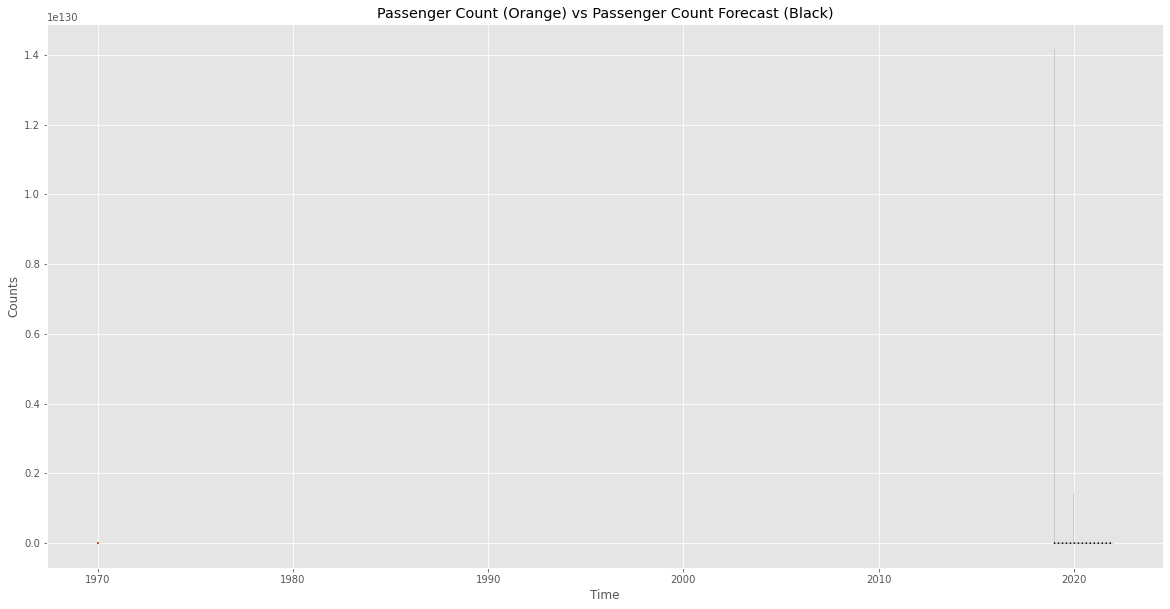

In [125]:
fig, ax1 = plt.subplots()
ax1.plot(viz_df.counts)
ax1.plot(viz_df.yhat, color='black', linestyle=':')
ax1.fill_between(viz_df.index, np.exp(viz_df['yhat_upper']), np.exp(viz_df['yhat_lower']), alpha=0.5, color='darkgray')
ax1.set_title('Passenger Count (Orange) vs Passenger Count Forecast (Black)')
ax1.set_ylabel('Counts')
ax1.set_xlabel('Time')

# L=ax1.legend() #get the legend
# L.get_texts()[0].set_text('Actual Sales') #change the legend text for 1st plot
# L.get_texts()[1].set_text('Forecasted Sales') #change the legend text for 2nd plot

This visualization is much better (in my opinion) than the default fbprophet plot. It is much easier to quickly understand and describe what's happening. The orange line is actual sales data and the black dotted line is the forecast. The gray shaded area is the uncertaintity estimation of the forecast.